# The Task at Hand

Have you ever wondered if computers could translate languages? Did you think google translate or duolingo worked because they memorized answers? 

The type of problem that translation solves is sequence to sequence. For instance, we could convert an english input sequence to a german output sequence. 

In this activity, we will create an english -> chinese translator and apply what we've been learning about LSTMs & RNNs.



## Preparing the data
We need to import our packages and data to learn a little bit about the problem at hand.

In [1]:
import numpy as np
import torch.nn as nn
from nltk.tokenize import WordPunctTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Word2Sequence import Word2Sequence
from Dataset import Dataset
from Seq2Seq import Seq2Seq

In [2]:
# read small_en-cn.txt file
data_path = './eng-chin.txt'
df = pd.read_table(data_path,header=None).iloc[:,:]
df = df.drop([2],axis=1)
df.columns=['english','chinese']

input_texts = df.english.values.tolist() #this will be all of the english sentences
target_texts = df.chinese.values.tolist() #this will be all of the chinese sentences

In [3]:
'''
Your code here: Try printing some english and chinese sentences from their lists input_texts and target_texts!
'''
print(target_texts)

['有没有一个国家比美国更提倡爱国主义？', '有空的时候，我总喜欢听古典音乐。', '我九岁的时候问我妈妈圣诞老人是否真的存在。', '我是外国人，我捷克语不好，请说慢一点。', '如果可能的話, 我希望你參加下一次的會議。', '如果你喜歡你做的工作，你就有比金錢更有價值的東西。', '直到我自己有了孩子我才明白了什么是母爱。', '善良是聾子能聽盲人能看的語言。', '玛丽哭着从学校跑回了家里，因为她的朋友捉弄了她。', '我爸爸对我的爱和照顾不比我妈妈少。', '现在是你决定是不是真要结婚的时候。', '人會因為體溫而在紅外線攝影機上顯現。', '警察大概从一个月前就开始找被偷物品了。', '他們告訴我吃完這個藥我就會覺得舒服一點。', '因为家里钱不够所以汤姆没能念大学。', '他的食物供给不足的的时候，他不得不去找新的地方居住。', '我昨晚在床上看书的时候点着灯就睡了。', '“你去哪儿了？”“我去了火车站送我的一个朋友。”', '对了，前些时间你说伞不见了，现在找到了吗？', '當她看到媽媽沒在生她的氣，她的雙眼因為幸福而閃爍了。', '我不用曲膝就能把我的手掌放到地上。', '我十八歲時，學了開車、考到了駕照。', '我十八歲時，學了開車、考到了駕照。', '我本来预备今天去海滩的，但接着天就开始下雨了。', '如果我们知道我们在做什么，那么这不能称之为研究，是吗？', '如果你想去，就去好了。如果你不想去，那也没什么大不了的。', '在美国，大多数人能在十八岁后投票选举。', '得不到的东西就最想得到。', '比起少抽菸，你何不直接把菸戒了？', '反社会者极少为他们的罪行显露懊悔或有罪恶的感觉。', '汤姆不能说明玛丽遇害那天自己在哪里。', '汤姆从没忘记在婚礼周年纪念日送给他妻子花。', '在巴黎，沒有人能夠理解湯姆的法文。', '我们那时在谈论事情，但我不记得是什么了。', '你不应该在社交网络上分享过多私人信息。', '湯姆失業後，為了排遣鬱悶的心情而開始了賭博。', '放學後，我到一所英語學校去練習英語會話。', '我想你要拿到驾照根本不难。', '我以为我们发现了绝妙的藏身之处，但警察找到了我们。', '我想知道最近的美國運通辦事處的電話號碼。', '她定期去看牙医，所以她很少牙痛。', '让事情更糟糕的是，他没有注意到他打扰到了邻

In [4]:
#read in our model object. Tokenize our data
tk = WordPunctTokenizer()
english = [tk.tokenize(sentence.lower()) for sentence in input_texts]
chinese = [[x for x in sentence] for sentence in target_texts]
english

[['does',
  'any',
  'other',
  'country',
  'fan',
  'the',
  'flames',
  'of',
  'patriotism',
  'as',
  'much',
  'as',
  'america',
  '?'],
 ['i',
  'always',
  'enjoy',
  'listening',
  'to',
  'classical',
  'music',
  'when',
  'i',
  'have',
  'some',
  'free',
  'time',
  '.'],
 ['i',
  'was',
  'nine',
  'years',
  'old',
  'when',
  'i',
  'asked',
  'my',
  'mom',
  'if',
  'santa',
  'claus',
  'really',
  'existed',
  '.'],
 ['i',
  "'",
  'm',
  'a',
  'foreigner',
  'and',
  'i',
  'don',
  "'",
  't',
  'know',
  'czech',
  'very',
  'well',
  '.',
  'please',
  ',',
  'speak',
  'slowly',
  '.'],
 ['if',
  'it',
  "'",
  's',
  'at',
  'all',
  'possible',
  ',',
  'i',
  "'",
  'd',
  'like',
  'you',
  'to',
  'take',
  'part',
  'in',
  'the',
  'next',
  'meeting',
  '.'],
 ['if',
  'you',
  'enjoy',
  'the',
  'work',
  'you',
  'do',
  ',',
  'you',
  'have',
  'something',
  'worth',
  'more',
  'than',
  'money',
  '.'],
 ['it',
  'was',
  'not',
  'until',
  

In [5]:
'''
Your code here: Explore this data. Can you calculate the maximum length of a sequence in each dataset english and chinese?
'''
# calculate max_len of any sequence in 'english' list and save it to a variable called max_english_length
max_english_length = max([len(seq) for seq in english])
print(max_english_length)
# calculate max_len of any sequence in 'chinese' list and save it to a variable called max_chinese_length
max_chinese_length = max([len(seq) for seq in chinese])
print(max_chinese_length)

25
39


In [6]:
input_tokenizer = Word2Sequence()
for words in english:
    input_tokenizer.fit(words)
input_tokenizer.build_vocab(min=1, max_features=None) #inpu

output_tokenizer = Word2Sequence()
for words in chinese:
    output_tokenizer.fit(words)
output_tokenizer.build_vocab(min=1, max_features=None)

'''
Your code here: print the total english words in your input tokenizer and total chinese words in your output tokenizer below!
'''
total_english_words = len(input_tokenizer)
print(total_english_words)

total_chinese_words = len(output_tokenizer)
print(total_chinese_words)

199
317


<h1>Creating the model</h1>

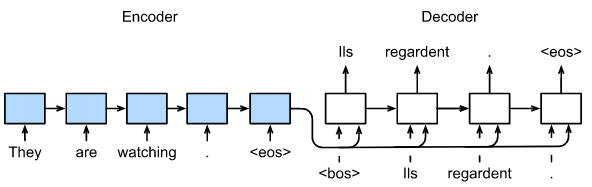

NOTE: For Structure of Encoder Inputs, they can all be either (assume all have same maxlen): 
1. \<SOS>, word1, word2, word3, ..., \<EOS>
2. word1, word2, word3, ..., \<EOS> 
3. word1, word2, word3, ...

NOTE: But Decoder In and Out structures should always look like this (assume all have same maxlen):
- Decoder Input: \<SOS>, word1, word2, word3, ...
- Decoder Output: word1, word2, word3, ..., \<EOS>  

This means that our input and ouput max length should be one more than the sequence's max length.

WHY? Data Structure:
- 1. Encoder Input: [word1, word2, ... + <EOS>]
- 2. Decoder Input: [<SOS> + word1, word2, ...]
- 3. Decoder Output:[word1, word2, ... + <EOS>]
    
nn docs - https://pytorch.org/docs/stable/nn.html

In [7]:
# Seq2Seq Parameters
in_maxlen = 25 + 1 # 25 + 1(<EOS> token)
out_maxlen = 39 + 1 # 39 + 1(<EOS> token or <SOS> token)
n_hidden = 32 # number of "neurons" per layer
d_model = 64 # number of embedding dimensions to represent each word
enc_n_class = len(input_tokenizer.dict) # OR... vocab size of englisth -> 199
dec_n_class = len(output_tokenizer.dict) # OR... vocab size of chinese -> 317
batch_size = 1

In [8]:
# max_english_length, max_chinese_length = 25, 39
eng_maxlen = max_english_length + 1 # 25 + 1(<EOS> token)
chin_maxlen = max_chinese_length + 1  # 39 + 1(<EOS> token or <SOS> token)
batch_size = 1

# Setup the Dataset.
dataset = Dataset(
    X = english,
    Y = chinese,
    in_tknz = input_tokenizer, out_tknz = output_tokenizer,
    in_maxlen = eng_maxlen, out_maxlen = chin_maxlen
)

'''
The following are helper functions to help pytorch. You won't need to know this much.
'''
# NOTE: collate_fn preprocesses your input from PyTorch Dataset above during PyTorch DataLoader
def collate_fn(batch):
    '''
    param batch: ([enc_in, dec_in, dec_out]， [enc_in, dec_in, dec_out], output of getitem...)
    '''
    # unpack values
    enc_in, dec_in, dec_out = list(zip(*batch))
    # Return tensor type
    return torch.LongTensor(enc_in), torch.LongTensor(dec_in), torch.LongTensor(dec_out)

def get_dataloader(dataset, batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn):
    '''
    Returns a way to access and use the data
    '''
    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            collate_fn=collate_fn)
    return dataloader
# Get PyTorch DataLoader
dataloader = get_dataloader(dataset, batch_size)
dataloader = get_dataloader(dataset, batch_size)

In [9]:
model = Seq2Seq(
    in_maxlen = in_maxlen,
    out_maxlen = out_maxlen,
    n_hidden = n_hidden,
    enc_n_class = len(input_tokenizer.dict),
    dec_n_class = len(output_tokenizer.dict),
    d_model = d_model,
    num_layers = 1,
)
model.to(device)
# # If you have saved a model before
# model.load_state_dict(torch.load("seq2seq.pt", map_location=device))

/projects/0ddeade5-3577-4fe8-8cd6-8a0cb653428e/miniconda3/envs/nlp_env/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Seq2Seq(
  (encoder): GRU(64, 32, dropout=0.3)
  (decoder): GRU(64, 32, dropout=0.3)
  (embed_enc): Embedding(199, 64)
  (embed_dec): Embedding(317, 64)
  (fc): Linear(in_features=32, out_features=317, bias=True)
)

In [10]:
# Define Loss and Optimizer -- these are ways we define performance for our model. If you're curious: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)

<h1>Training our model</h1>

In [11]:
'''
Your code here: change the number of epochs to see how it effects training time and quality
'''
epochs = 500


'''
Training -- no need to touch the code below.
'''
torch.cuda.empty_cache()
model.train()
model.to(device)
loss_records = []


for epoch in range(epochs):
    # runs the model and calculates loss
    loss = 0
    for _, (enc_in, dec_in, dec_out) in enumerate(dataloader):
        # enc_h_0.shape: [1(num_layers), 1(batch_size), 32(hidden_size)]
        enc_h_0 = model.init_enc_hidden_GRU(batch_size, device)
        # To Cuda Device if available
        enc_in, dec_in = enc_in.to(device), dec_in.to(device)
        
        pred = model(enc_in, enc_h_0, dec_in)
        
        dec_out = dec_out.to(device)
        for i in range(len(dec_out)): # dec_in.shape: [1(b), 40(out_maxlen)]
            # pred[i].shape: [40(out_maxlen), 317(dec_n_class)]
            # dec_out[i].shape: [40(out_maxlen)]
            loss += criterion(pred[i], dec_out[i])

    if (epoch) % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")

    if (epoch) % 100 == 0:
        loss_records.append(loss)
    
    # runs the actual back propacation
    optim.zero_grad()
    loss.backward()
    optim.step()
    torch.save(model.state_dict(), "seq2seq.pt")

Epoch: 0, Loss: 576.2747802734375


Epoch: 10, Loss: 280.32415771484375


Epoch: 20, Loss: 238.6700897216797


Epoch: 30, Loss: 217.3397674560547


Epoch: 40, Loss: 193.51229858398438


Epoch: 50, Loss: 168.69577026367188


Epoch: 60, Loss: 144.92808532714844


Epoch: 70, Loss: 123.36004638671875


Epoch: 80, Loss: 104.08132934570312


Epoch: 90, Loss: 87.08438873291016


Epoch: 100, Loss: 72.41958618164062


Epoch: 110, Loss: 59.867557525634766


Epoch: 120, Loss: 49.38654708862305


Epoch: 130, Loss: 40.73469161987305


Epoch: 140, Loss: 33.71730041503906


Epoch: 150, Loss: 28.130598068237305


Epoch: 160, Loss: 23.55632781982422


Epoch: 170, Loss: 19.924890518188477


Epoch: 180, Loss: 16.938188552856445


Epoch: 190, Loss: 14.635987281799316


Epoch: 200, Loss: 12.67483139038086


Epoch: 210, Loss: 11.050590515136719


Epoch: 220, Loss: 9.96059513092041


Epoch: 230, Loss: 8.723247528076172


Epoch: 240, Loss: 7.7913641929626465


Epoch: 250, Loss: 7.6860761642456055


Epoch: 260, Loss: 6.983063220977783


Epoch: 270, Loss: 6.475579738616943


Epoch: 280, Loss: 5.597828388214111


Epoch: 290, Loss: 5.036618709564209


Epoch: 300, Loss: 4.595510482788086


Epoch: 310, Loss: 4.232182502746582


Epoch: 320, Loss: 3.958742618560791


Epoch: 330, Loss: 3.670031785964966


Epoch: 340, Loss: 3.41642165184021


Epoch: 350, Loss: 3.19545316696167


Epoch: 360, Loss: 2.9968225955963135


Epoch: 370, Loss: 2.8598716259002686


Epoch: 380, Loss: 2.6651551723480225


Epoch: 390, Loss: 2.5117602348327637


Epoch: 400, Loss: 2.38970947265625


Epoch: 410, Loss: 2.2810122966766357


Epoch: 420, Loss: 2.163372039794922


Epoch: 430, Loss: 2.044552803039551


Epoch: 440, Loss: 1.9543917179107666


Epoch: 450, Loss: 1.8725786209106445


Epoch: 460, Loss: 1.7766356468200684


Epoch: 470, Loss: 1.69122314453125


Epoch: 480, Loss: 1.9904934167861938


Epoch: 490, Loss: 9.795100212097168


## Let's check out our model's progress
No need to change the code below, this will plot our loss over time. How do you think we can tweak our code to decrease loss even further?

In [12]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points): # Helper function for showing our plots
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

<Figure size 432x288 with 0 Axes>

Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 3158 ticks ([-26.400000000000002, ..., 605.0000000000001]), which exceeds Locator.MAXTICKS (1000).


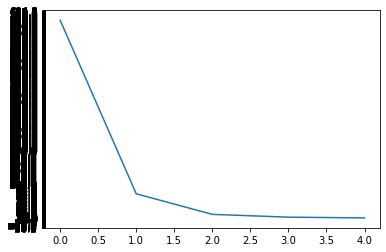

In [13]:
showPlot([loss.cpu().item() for loss in loss_records])

<h1>Code for Translating with our Model</h1>
This is where the Seq2Seq happens after the model is trained.


In [18]:
'''
No need to touch this code: 
'''

def translate(eng_sent, model, device):
    # set up the inputs and variables
    model.eval()
    model.to(device)
    eng_sent = tk.tokenize(eng_sent.lower()) + ["<EOS>"]
    eng_sent = input_tokenizer.transform(eng_sent, max_len=in_maxlen, pad_first=False)
    dec_in = (["<SOS>"] + ["<PAD>"]*out_maxlen)[:out_maxlen]
    dec_in = output_tokenizer.transform(dec_in, max_len=out_maxlen, pad_first=False)
    
    enc_h_0 = model.init_enc_hidden_GRU(batch_size, device)
    eng_sent, dec_in = torch.LongTensor(eng_sent), torch.LongTensor(dec_in)

    eng_sent = eng_sent.unsqueeze(0)
    dec_in = dec_in.unsqueeze(0)
    eng_sent, dec_in = eng_sent.to(device), dec_in.to(device)

    # run the model
    with torch.no_grad():
        # eng_sent: [1(b), 26(in_maxlen)]
        embedded_X = model.embed_enc(eng_sent)
        # embedded_X: [26(in_maxlen), 1(b), 64(d_model)] <- [1(b), 26(in_maxlen), 64(d_model)]
        embedded_X = embedded_X.permute(1, 0, 2)
        _, memory = model.encoder(embedded_X, enc_h_0)
        pred_loc = 0
        for i in range(out_maxlen-1):
            embedded_Y = model.embed_dec(dec_in)
            embedded_Y = embedded_Y.permute(1, 0, 2)
            outputs, _ = model.decoder(embedded_Y, memory)
            outputs = outputs.permute(1, 0, 2)
            pred = model.fc(outputs)
            pred = pred[0][pred_loc].topk(1)[1].item()
            pred_loc += 1
            if pred == 2:
                dec_in[0][pred_loc] = pred
                break
            else:
                dec_in[0][pred_loc] = pred
    return dec_in

# Using our Model in Practice
Check out these examples below. This is how you can translate sequences!

In [19]:
import random
eng_sents = random.sample(input_texts, 5)
for sent in eng_sents:
  translated = translate(sent, model, torch.device("cpu"))
  translated_sent = output_tokenizer.inverse_transform(translated[0], is_tensor=True)
  translated_sent = "".join([word for word in translated_sent if word != "<SOS>" and word != "<EOS>"and word != "<PAD>"])
  print(f"{sent} -> \n{translated_sent}")

The importation of rare wild animals to this country is strictly prohibited. -> 
该国<UNK><UNK><UNK>口<UNK>有野生<UNK>物。
Charles Lindbergh made the first solo flight across the Atlantic Ocean in 1927. -> 
<UNK>har<UNK>e<UNK> <UNK><UNK><UNK><UNK><UNK>er<UNK>h於192<UNK>年成<UNK>完成了<UNK>一次<UNK>自飛<UNK>大西<UNK>。
We were talking about something at that time, but I don't remember what. -> 
我们那时在<UNK>论事情，但我不记得是什么了。
I'm a foreigner and I don't know Czech very well. Please, speak slowly. -> 
我是外国人，<UNK>的<UNK>语不好，<UNK>说<UNK>一点。
If it's at all possible, I'd like you to take part in the next meeting. -> 
如果你想去，就去好了。如果你不想去，那也没什么大不了的。


# Your turn!

Can you use the code in the cell above to translate custom sentences? 



In [20]:
'''
Your code here: translate custom sentences using the code above. Hint: You won't need a for loop!
'''
eng_sents = ['I am a student.', 'What']
for sent in eng_sents:
  translated = translate(sent, model, torch.device("cpu"))
  translated_sent = output_tokenizer.inverse_transform(translated[0], is_tensor=True)
  translated_sent = "".join([word for word in translated_sent if word != "<SOS>" and word != "<EOS>"and word != "<PAD>"])
  print(f"{sent} -> \n{translated_sent}")

I am a student. -> 
我想知道这个城市，而且我一点都不懂那里的语言。
What -> 
我想知道最<UNK>的美國<UNK>通<UNK>事<UNK>的電話<UNK><UNK>。
